In [7]:
# # Import required libraries
import numpy as np

# Load the dataset
data = []
with open('all_sentiment_shuffled.txt', encoding='utf-8') as file:
    for line in file:
        data.append(line.strip())


In [18]:
# Preprocess the Dataset
texts = []  # List to store the preprocessed texts
labels = []  # List to store the sentiment labels

for line in data:
    columns = line.split(' ')  # Split line by spaces
    label = columns[1]  # Extract the sentiment label
    text = ' '.join(columns[3:])  # Join the remaining columns to form the text
    texts.append(text)
    labels.append(label)
    
split_point = int(0.80 * len(texts))
train_docs = texts[:split_point]
train_labels = labels[:split_point]
eval_docs = texts[split_point:]
eval_labels = labels[split_point:]

In [19]:
# Print a few examples of the preprocessed texts and their corresponding labels to verify the preprocessing.
for i in range(5):  # Print the first 5 examples
    print("Text:", texts[i])
    print("Label:", labels[i])
    print()


Text: i bought this album because i loved the title song . it 's such a great song , how bad can the rest of the album be , right ? well , the rest of the songs are just filler and are n't worth the money i paid for this . it 's either shameless bubblegum or oversentimentalized depressing tripe . kenny chesney is a popular artist and as a result he is in the cookie cutter category of the nashville music scene . he 's gotta pump out the albums so the record company can keep lining their pockets while the suckers out there keep buying this garbage to perpetuate more garbage coming out of that town . i 'll get down off my soapbox now . but country music really needs to get back to it 's roots and stop this pop nonsense . what country music really is and what it is considered to be by mainstream are two different things .
Label: neg

Text: i was misled and thought i was buying the entire cd and it contains one song
Label: neg

Text: i have introduced many of my ell , high school students t

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_label_distribution(true_labels, predicted_labels):
    labels = np.unique(true_labels)
    true_counts = [true_labels.count(label) for label in labels]
    predicted_counts = [predicted_labels.count(label) for label in labels]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, true_counts, width, label='True Labels')
    rects2 = ax.bar(x + width/2, predicted_counts, width, label='Predicted Labels')

    ax.set_xlabel('Sentiment Labels')
    ax.set_ylabel('Counts')
    ax.set_title('Distribution of True and Predicted Labels')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()


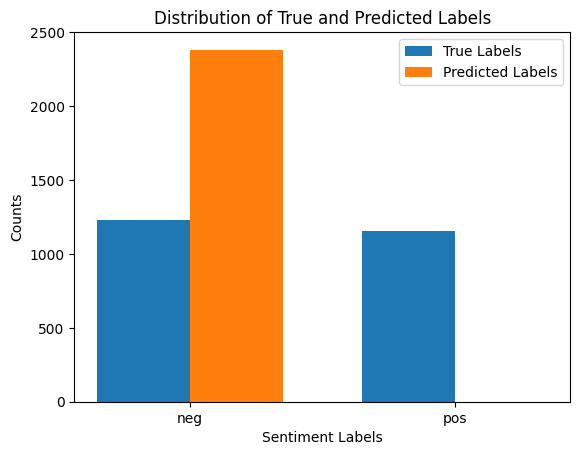

In [38]:
plot_label_distribution(eval_labels, test_predictions)

In [20]:
# Python function that uses a training set of documents to estimate the probabilities in the Naive Bayes model

from collections import defaultdict

def train_nb(documents, labels, alpha=1.0):
    word_counts = defaultdict(lambda: {'pos': 0, 'neg': 0})
    class_counts = {'pos': 0, 'neg': 0}

    for doc, label in zip(documents, labels):
        for word in doc:
            word_counts[word][label] += 1
        class_counts[label] += 1

    total_docs = len(documents)
    class_priors = {label: count / total_docs for label, count in class_counts.items()}

    vocabulary = set(word for doc in documents for word in doc)
    vocab_size = len(vocabulary)

    # Apply smoothing
    smoothed_word_counts = defaultdict(lambda: {'pos': alpha, 'neg': alpha})
    for word in vocabulary:
        for label in ['pos', 'neg']:
            smoothed_word_counts[word][label] += word_counts[word][label]

    # Calculate probabilities
    word_probs = defaultdict(lambda: {'pos': 0.0, 'neg': 0.0})
    for word in vocabulary:
        for label in ['pos', 'neg']:
            word_probs[word][label] = smoothed_word_counts[word][label] / (class_counts[label] + alpha * vocab_size)

    return word_probs, class_priors, vocab_size


In [21]:
# Classifying new documents
import math

def score_doc_label(document, label, word_probs, class_priors, vocab_size):
    log_prob = math.log(class_priors[label])
    for word in document:
        if word in word_probs:
            log_prob += math.log(word_probs[word][label])
    return log_prob


In [22]:
import numpy as np

def score_doc_label(document, label, word_probs, class_priors, vocab_size):
    log_prob = 0.0
    for word in document:
        if word in word_probs:
            log_prob += np.log(word_probs[word][label])

    log_prob += np.log(class_priors[label])

    return log_prob


In [23]:
# Sanity check 1. 
word_probs, class_priors, vocab_size = train_nb(train_docs, train_labels)

document = ["great"]
label = "pos"
log_prob = score_doc_label(document, label, word_probs, class_priors, vocab_size)
prob = np.exp(log_prob)
print(f"Log Probability of positive document with the word 'great': {log_prob}")
print(f"Probability of positive document with the word 'great': {prob}")


Log Probability of positive document with the word 'great': -0.6761896870922498
Probability of positive document with the word 'great': 0.5085510439618088


In [24]:
# Next, based on the function you just wrote, write another function that classifies a new document.

def classify_nb(document, word_probs, class_priors, vocab_size):
    pos_log_prob = score_doc_label(document, "pos", word_probs, class_priors, vocab_size)
    neg_log_prob = score_doc_label(document, "neg", word_probs, class_priors, vocab_size)

    if pos_log_prob > neg_log_prob:
        return "pos"
    else:
        return "neg"


In [25]:
# Sanity check 2. 
word_probs, class_priors, vocab_size = train_nb(train_docs, train_labels)

document1 = ["great"]
classification1 = classify_nb(document1, word_probs, class_priors, vocab_size)
print(f"Classification of document1: {classification1}")

document2 = ["bad"]
classification2 = classify_nb(document2, word_probs, class_priors, vocab_size)
print(f"Classification of document2: {classification2}")


Classification of document1: pos
Classification of document2: pos


In [26]:
# Evaluating the classifier
## Write a function that classifies each document in the test set and returns the list of predicted sentiment labels.

def classify_documents(docs, word_probs, class_priors, vocab_size):
    predictions = []
    for doc in docs:
        label = classify_nb(doc, word_probs, class_priors, vocab_size)
        predictions.append(label)
    return predictions


In [28]:
# Let's use the classify_documents function to classify all the documents in the test set.

word_probs, class_priors, vocab_size = train_nb(train_docs, train_labels)

test_predictions = classify_documents(eval_docs, word_probs, class_priors, vocab_size)
test_predictions

['neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',


In [30]:
# # Next, we compute the accuracy, i.e. the number of correctly classified documents divided by the total number of documents.

def accuracy(true_labels, guessed_labels):
    correct = sum(1 for true, guessed in zip(true_labels, guessed_labels) if true == guessed)
    total = len(true_labels)
    accuracy = correct / total
    return accuracy

# Let's compute the accuracy of the classifier on the test set
test_accuracy = accuracy(eval_labels, test_predictions)
print(f"Accuracy on the test set: {test_accuracy}")


Accuracy on the test set: 0.5165757448594209


In [32]:
# Error analysis
# Find a few misclassified documents and comment on why you think they were hard to classify. For instance, you may select a few short documents where the probabilities were particularly high in the wrong direction.

def error_analysis(true_labels, guessed_labels, documents):
    misclassified_docs = []
    for true, guessed, doc in zip(true_labels, guessed_labels, documents):
        if true != guessed:
            misclassified_docs.append((true, guessed, doc))
    return misclassified_docs

misclassified = error_analysis(eval_labels, test_predictions, eval_docs)

for true, guessed, doc in misclassified:
    print(f"True Label: {true}, Guessed Label: {guessed}")
    print(f"Document: {doc}")
    print("-----")


True Label: pos, Guessed Label: neg
Document: the series just keeps on getting better . the bob newhart show was one of the best comedies ever on television . the other funny show was " newhart " , which i cannot understand why it has not been released on dvd . the whole cast just clicks . i wish shows like this were still on television . if you enjoy a good laugh then buy this and the other sets !
-----
True Label: pos, Guessed Label: neg
Document: i highly recommend this super wide angle lens for anyone wanting to take landscape pictures , buildings or lots of other stuff ! it is so different than the standard kit lens ( 18-55 ) . you wo n't be sorry when you start learning all the possibilities of the extraordinary lens
-----
True Label: pos, Guessed Label: neg
Document: this is one of the better historical dramas from the 1970s . many are stagey and slow , and while this production of madame bovary is very much constrained to stay indoors , this works to advantage for this story of

In [33]:
# Implement the cross-validation method. 
from sklearn.model_selection import KFold

def cross_validation(docs, labels, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True)
    accuracies = []

    for train_index, eval_index in kf.split(docs):
        train_docs_fold = [docs[i] for i in train_index]
        train_labels_fold = [labels[i] for i in train_index]
        eval_docs_fold = [docs[i] for i in eval_index]
        eval_labels_fold = [labels[i] for i in eval_index]

        word_probs, class_priors, vocab_size = train_nb(train_docs_fold, train_labels_fold)
        fold_predictions = classify_documents(eval_docs_fold, word_probs, class_priors, vocab_size)
        fold_accuracy = accuracy(eval_labels_fold, fold_predictions)
        accuracies.append(fold_accuracy)

    mean_accuracy = np.mean(accuracies)
    std_dev = np.std(accuracies)
    interval = (mean_accuracy - 2 * std_dev, mean_accuracy + 2 * std_dev)

    return mean_accuracy, interval


In [35]:
# Then estimate the accuracy and compute a new interval estimate. A typical value of N would be between 4 and 10.

num_folds = 5
mean_accuracy, interval = cross_validation(train_docs, train_labels, num_folds)
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Interval Estimate: {interval}")

Mean Accuracy: 0.5072929522920747
Interval Estimate: (0.47057841017490015, 0.5440074944092493)


In [40]:
def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    labels = np.unique(true_labels)

    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels, ax=ax)

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')

    plt.show()

In [41]:
plot_confusion_matrix(eval_labels, test_predictions)